# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science: 
## Homework 3 - Forecasting Bike Sharing Usage



**Harvard University**<br/>
**Fall 2018**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader

<hr style="height:2pt">

In [3]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 
- As much as possible, try and stick to the hints and functions we import at the top of the homework, as those are the ideas and tools the class supports and is aiming to teach. And if a problem specifies a particular library you're required to use that library, and possibly others from the import list.

Names of people you have worked with goes here: 

<hr style="height:2pt">

![bike_sharing](fig/BSS.png)

<div class="theme">  Main Theme: Multiple Linear Regression, Subset Selection, Polynomial Regression </div>
### Overview 

You are hired by the administrators of the [Capital Bikeshare program](https://www.capitalbikeshare.com) program in Washington D.C., to **help them predict the hourly demand for rental bikes** and **give them suggestions on how to increase their revenue**. Your task is to prepare a short report summarizing your findings and make recommendations.

The predicted hourly demand could be used for planning the number of bikes that need to be available in the system at any given hour of the day. It costs the program money if bike stations are full and bikes cannot be returned, or empty and there are no bikes available. You will use multiple linear regression and polynomial regression and will explore techniques for subset selection to predict bike usage. The goal is to build a regression model that can predict the total number of bike rentals in a given hour of the day, based on all available information given to you. 

An example of a suggestion to increase revenue might be to offer discounts during certain times of the day either during holidays or non-holidays. Your suggestions will depend on your observations of the seasonality of ridership.

The data for this problem were collected from the Capital Bikeshare program over the course of two years (2011 and 2012).


### Use only the libraries below:

In [626]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.api import OLS

from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from pandas.plotting import scatter_matrix

import seaborn as sns


%matplotlib inline

#### HW3 specific imports, reference to Section 3

import matplotlib.patches as mpatches
matplotlib.rcParams['figure.figsize'] = (13.0, 6.0)
# Other Helpful fucntions
import itertools
import warnings
warnings.filterwarnings("ignore")

#Aesthetic settings
from IPython.display import display
pd.set_option('display.max_rows', 999)
pd.set_option('display.width', 500)
pd.set_option('display.notebook_repr_html', True)

## Data Exploration & Preprocessing, Multiple Linear Regression, Subset Selection


### Overview
The initial data set is provided in the file `data/BSS_hour_raw.csv`. You will first add features that will help with the analysis and then separate the data into training and test sets. Each row in this file represents the number of rides by registered users and casual users in a given hour of a specific date. There are 12 attributes in total describing besides the number of users the weather if it is a holiday or not etc: 


- `dteday` (date in the format YYYY-MM-DD, e.g. 2011-01-01)
- `season` (1 = winter, 2 = spring, 3 = summer, 4 = fall)
- `hour` (0 for 12 midnight, 1 for 1:00am, 23 for 11:00pm)
- `weekday` (0 through 6, with 0 denoting Sunday)
- `holiday` (1 = the day is a holiday, 0 = otherwise)
- `weather`
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm
    - 4: Heavy Rain + Thunderstorm + Mist, Snow + Fog 
- `temp` (temperature in Celsius)
- `atemp` (apparent temperature, or relative outdoor temperature, in Celsius)
- `hum` (relative humidity)
- `windspeed` (wind speed)
- `casual` (number of rides that day made by casual riders, not registered in the system)
- `registered` (number of rides that day made by registered riders)

### General Hints
- Use pandas .describe() to see statistics for the dataset.
- When performing manipulations on column data it is useful and often more efficient to write a function and apply this function to the column as a whole without the need for iterating through the elements.
- A scatterplot matrix or correlation matrix are both good ways to see dependencies between multiple variables.
- For Question 2, a very useful pandas method is .groupby(). Make sure you aggregate the rest of the columns in a meaningful way. Print the dataframe to make sure all variables/columns are there!

### Resources 
http://pandas.pydata.org/pandas-docs/stable/generated/pandas.to_datetime.html

<div class="exercise"> <b> Question 1: Data Read-In and Cleaning </b> </div>

In this section, we read in the data and begin one of the most important analytic steps: verifying that the data is what it claims to be.

**1.1** Load the dataset from the csv file `data/BSS_hour_raw.csv` into a pandas dataframe that you name `bikes_df`. Do any of the variables' ranges or averages seem suspect? Do the data types make sense?

**1.2** Notice that the variable in column `dteday` is a pandas `object`, which is **not**  useful when you want to extract the elements of the date such as the year, month, and day. Convert `dteday` into a `datetime` object to prepare it for later analysis.

**1.3** Create three new columns in the dataframe:
- `year` with 0 for 2011, 1 for 2012, etc.
- `month` with 1 through 12, with 1 denoting January.
- `counts` with the total number of bike rentals for that day (this is the response variable for later).

### Answers

#### **1.1** Load the dataset from the csv file `data/BSS_hour_raw.csv` into a pandas dataframe that you name `bikes_df`. Do any of the variables' ranges or averages seem suspect? Do the data types make sense?

In [253]:
# your code here
bikes_df = pd.read_csv('data/BSS_hour_raw.csv')

In [35]:
# your code here
bikes_df.describe()

,season,hour,holiday,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,2.501640,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869
std,1.106918,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286
min,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000
50%,3.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000
75%,3.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000
max,4.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000


In [36]:
# your code here
bikes_df.dtypes

dteday         object
season          int64
hour            int64
holiday         int64
weekday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
dtype: object

*Your answer here*
temp, atemp, hum, windspeed values do not seem to be in standard units (Celcius, celcius, relative humidity, m/s) as expected. They look like a percentage value of a baseline temperature.
The data type for dteday is an object, this should be transformed to a date for better manipulation.

#### **1.2** Notice that the variable in column `dteday` is a pandas `object`, which is **not**  useful when you want to extract the elements of the date such as the year, month, and day. Convert `dteday` into a `datetime` object to prepare it for later analysis.

In [254]:
# your code here
bikes_df.dteday = pd.to_datetime(bikes_df.dteday, format='%Y-%m-%d')
bikes_df.dtypes

dteday        datetime64[ns]
season                 int64
hour                   int64
holiday                int64
weekday                int64
workingday             int64
weather                int64
temp                 float64
atemp                float64
hum                  float64
windspeed            float64
casual                 int64
registered             int64
dtype: object

#### **1.3** Create three new columns in the dataframe:
- `year` with 0 for 2011, 1 for 2012, etc.
- `month` with 1 through 12, with 1 denoting January.
- `counts` with the total number of bike rentals for that day (this is the response variable for later).

In [255]:
# your code here
bikes_df['year'] = bikes_df.dteday.dt.year - 2011
bikes_df['month'] = bikes_df.dteday.dt.month
bikes_df['counts'] = bikes_df.casual + bikes_df.registered


In [40]:
# your code here
bikes_df.head()


,dteday,season,hour,holiday,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered,year,month,counts
0,2011-01-01,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,0,1,16
1,2011-01-01,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,0,1,40
2,2011-01-01,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,0,1,32
3,2011-01-01,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,0,1,13
4,2011-01-01,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,0,1,1


<div class='exercise'> <b> Question 2: Exploratory Data Analysis. </b></div>

In this question, we continue validating the data, and begin hunting for patterns in ridership that shed light on who uses the service and why.

**2.1** Use pandas' `scatter_matrix` command to visualize the inter-dependencies among all predictors in the dataset.  Note and comment on any strongly related variables. [This will take several minutes to run. You may wish to comment it out until your final submission, or only plot a randomly-selected 10% of the rows]

**2.2** Make a plot showing the _average_ number of casual and registered riders during each hour of the day. `.groupby` and `.aggregate` should make this task easy. Comment on the trends you observe. 

**2.3** Use the variable `weather` to show how each weather category affects the relationships in question 2.2.  What do you observe?

**2.4** Make a new dataframe with the following subset of attributes from the previous dataset and with each entry being just **one** day: 

- `dteday`, the timestamp for that day (fine to set to noon or any other time) 
- `weekday`, the day of the week
- `weather`, the most severe weather that day
- `season`, the season that day falls in
- `temp`, the average temperature (normalized)
- `atemp`, the average atemp that day (normalized)
- `windspeed`, the average windspeed that day (normalized)
- `hum`, the average humidity that day (normalized)
- `casual`, the **total** number of rentals by casual users
- `registered`, the **total** number of rentals by registered users
- `counts`, the **total** number of rentals of that day

Name this dataframe `bikes_by_day`.

Make a plot showing  the _distribution_ of the number of casual and registered riders on each day of the week.

**2.5** Use `bikes_by_day` to visualize how the distribution of **total number of rides** per day (casual and registered riders combined) varies with the **season**. Do you see any **outliers**? Here we use the pyplot's boxplot function definition of an outlier as any value 1.5 times the IQR above the 75th percentile or 1.5 times the IQR below the 25th percentiles. If you see any outliers, identify those dates and investigate if they are a chance occurence, an error in the data collection, or a significant event (an online search of those date(s) might help). 



### Answers

#### **2.1** Use pandas' `scatter_matrix` command to visualize the inter-dependencies among all predictors in the dataset.  Note and comment on any strongly related variables. [This will take several minutes to run. You may wish to comment it out until your final submission, or only plot a randomly-selected 10% of the rows]

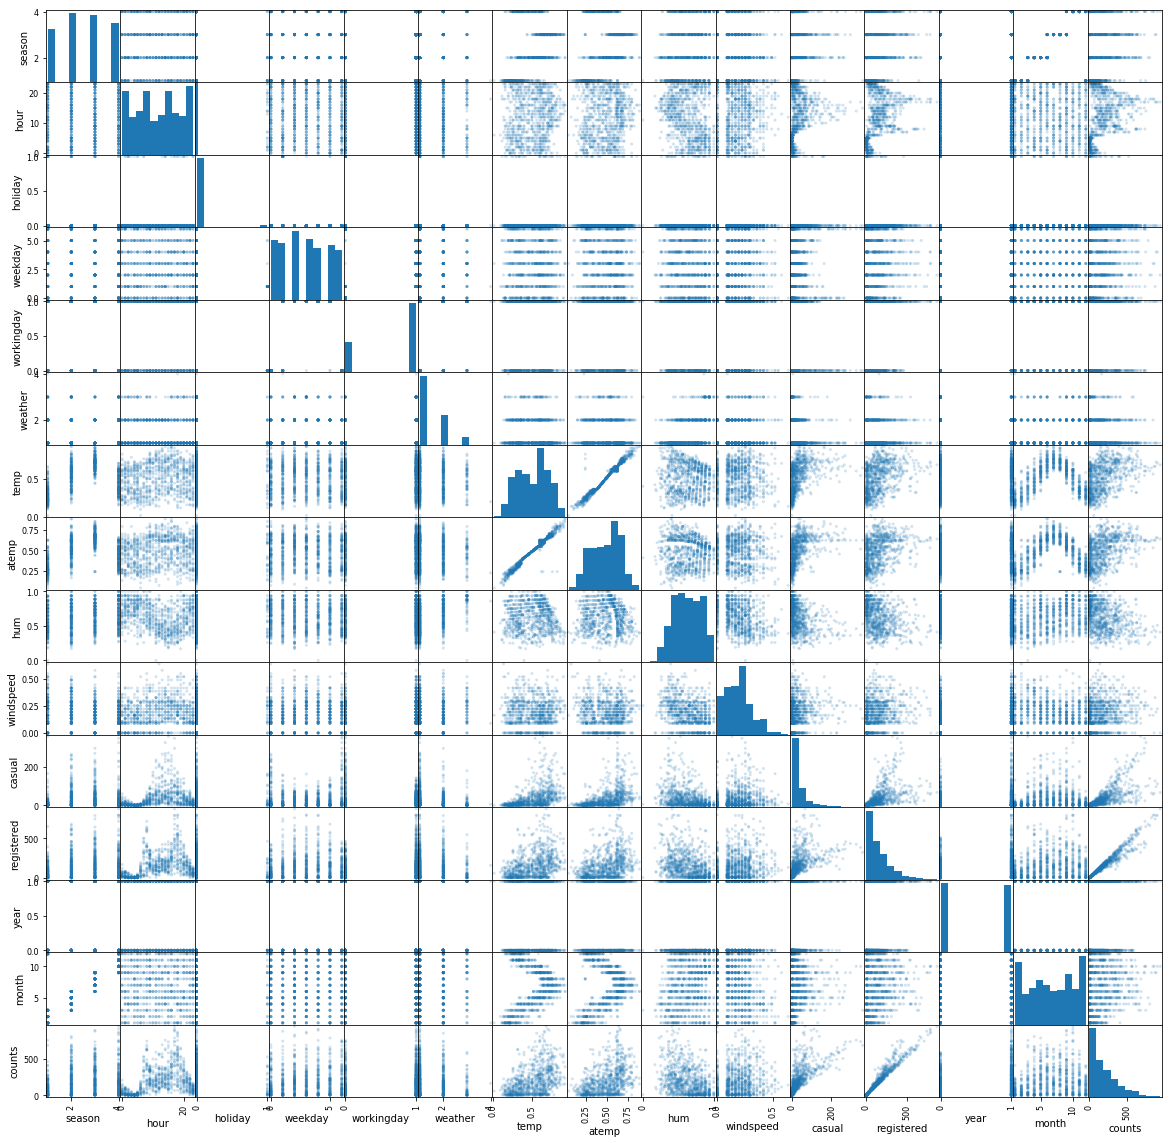

In [26]:
# your code here
bikes_df_5 = bikes_df.sample(frac=0.05)
pd.plotting.scatter_matrix(bikes_df_5, alpha=0.2, figsize=(20, 20))
plt.show()

*your answer here* 
We can observe a strong linear relationship between following pairs:
counts - temp
counts - atemp
counts - windspeed

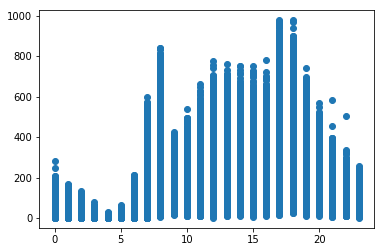

In [52]:
plt.scatter(bikes_df.hour, bikes_df.counts)
#bikes_df.hour.hist()

#### **2.2** Make a plot showing the _average_ number of casual and registered riders during each hour of the day. `.groupby` and `.aggregate` should make this task easy. Comment on the trends you observe. 

In [680]:
# your code here
hourly_bikes_df = bikes_df.groupby('hour').agg({
    'casual': np.mean,
    'registered': np.mean
})
hourly_bikes_df = hourly_bikes_df.round()
hourly_bikes_df.casual = hourly_bikes_df.casual.astype('int32')
hourly_bikes_df.registered = hourly_bikes_df.registered.astype('int32')
hourly_bikes_df

,casual,registered
hour,,
0,10,44
1,7,27
2,5,18
3,3,9
4,1,5
5,1,18
6,4,72
7,11,201
8,22,337


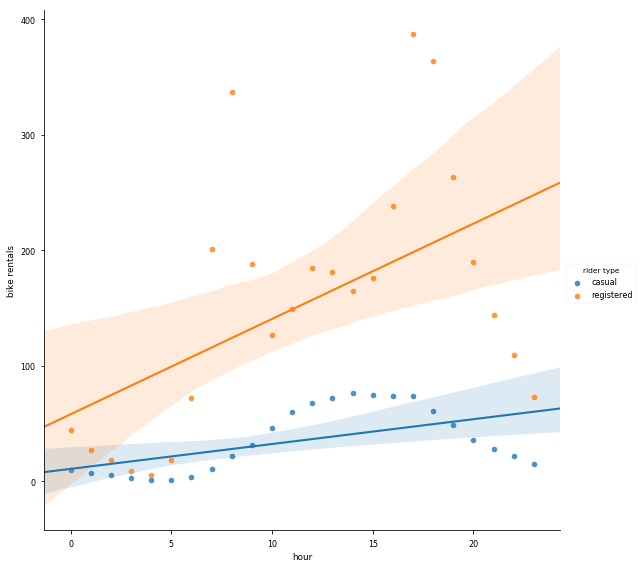

In [688]:
tidy_hourly_bikes_df = (
    hourly_bikes_df.stack() # pull the columns into row variables   
      .to_frame() # convert the resulting Series to a DataFrame
      .reset_index() # pull the resulting MultiIndex into the columns
      .rename(columns={0: 'bike rentals', 'level_1': 'rider type'}) # rename the unnamed column
)
tidy_hourly_bikes_df
sns.lmplot(x = 'hour', y = 'bike rentals', hue = 'rider type', data = tidy_hourly_bikes_df, size = 8)

**Comments on trend**

We see that there is a clear difference in the trend between casual and registered. The overall trend is an increasing linear over the 24 hours cycle.  But there is a difference between the two type of bikers. The graph representing the casual bikers is a smooth curve while the graph representing registered bikers show a greater variation. 

Bikes are rent mostly between 5 AM and 8 PM on average. Registered users rent more bikes than casual users on average. There are two picks in average bike rentals by registered users: around 8 AM and 5 PM. 

#### **2.3** Use the variable `weather` to show how each weather category affects the relationships in question 2.2.  What do you observe?

In [722]:
weather_hourly_bikes_df = bikes_df.groupby(['hour', 'weather']).agg({
    'casual': np.mean,
    'registered': np.mean
})
weather_hourly_bikes_df = weather_hourly_bikes_df.round()
weather_hourly_bikes_df.casual = weather_hourly_bikes_df.casual.astype('int32')
weather_hourly_bikes_df.registered = weather_hourly_bikes_df.registered.astype('int32')
weather_hourly_bikes_df

casual  registered
hour weather                    
0    1            11          48
     2             9          39
     3             4          25
1    1             7          27
     2             7          29
     3             2          15
     4             1          22
2    1             5          18
     2             5          21
     3             3          12
3    1             3           9
     2             3          10
     3             1           6
4    1             1           5
     2             1           5
     3             1           4
5    1             2          19
     2             1          19
     3             1          13
6    1             5          75
     2             4          71
     3             2          54
7    1            12         207
     2            11         214
     3             6         125
8    1            23         338
     2            22         369
     3             9         204
9    1            35         192
     2            29         198
     3            11         118
10   1            54         139
     2            40         119
     3            13          65
11   1            71         163
     2            47         136
     3            15          71
12   1            80         202
     2            54         172
     3            34         103
13   1            85         198
     2            56         170
     3            26          90
14   1            88         181
     2            57         151
     3            33          89
15   1            85         190
     2            61         167
     3            36         102
16   1            81         255
     2            70         229
     3            30         137
     4             1          35
17   1            81         419
     2            67         355
     3            39         237
18   1            68         390
     2            53         337
     3            28         243
     4             6         158
19   1            54         282
     2            40         242
     3            23         156
20   1            41         204
     2            29         175
     3            17         109
21   1            32         155
     2            23         129
     3            13          86
22   1            25         118
     2            19          98
     3             9          62
23   1            17          77
     2            14          71
     3             9          41

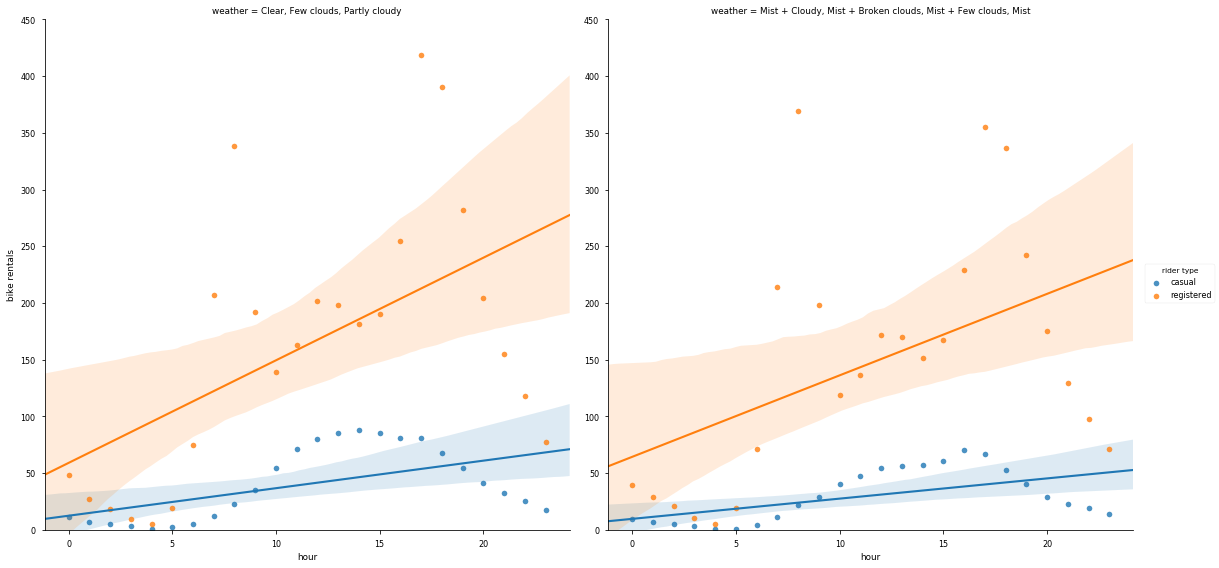

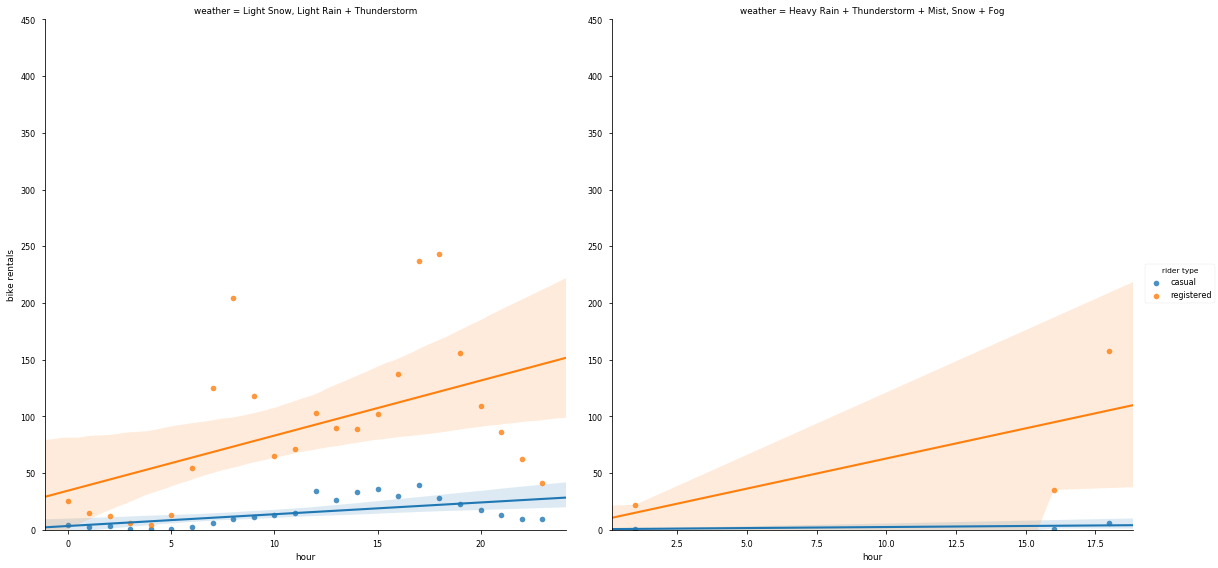

In [781]:
tidy_weather_hourly_bikes_df = (
    hourly_bikes_df.stack() # pull the columns into row variables   
      .to_frame() # convert the resulting Series to a DataFrame
      .reset_index() # pull the resulting MultiIndex into the columns
      .rename(columns={0: 'bike rentals', 'level_2': 'rider type', 'weather': 'weather_code'}) # rename the unnamed column
)
tidy_weather_hourly_bikes_df['weather'] = tidy_weather_hourly_bikes_df.weather_code
tidy_weather_hourly_bikes_df.weather = tidy_weather_hourly_bikes_df.weather.replace(1, 'Clear, Few clouds, Partly cloudy')
tidy_weather_hourly_bikes_df.weather = tidy_weather_hourly_bikes_df.weather.replace(2, 'Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist')
tidy_weather_hourly_bikes_df.weather = tidy_weather_hourly_bikes_df.weather.replace(3, 'Light Snow, Light Rain + Thunderstorm')
tidy_weather_hourly_bikes_df.weather = tidy_weather_hourly_bikes_df.weather.replace(4, 'Heavy Rain + Thunderstorm + Mist, Snow + Fog')

tidy_weather_hourly_bikes_df
g = sns.lmplot(x = 'hour', y = 'bike rentals', hue = 'rider type', col = 'weather', 
           data = tidy_weather_hourly_bikes_df[(tidy_weather_hourly_bikes_df.weather_code==1) | 
                                               (tidy_weather_hourly_bikes_df.weather_code==2)], 
           size = 8, sharex=False, sharey=False)
g.set(ylim=(0, 450))
g = sns.lmplot(x = 'hour', y = 'bike rentals', hue = 'rider type', col = 'weather', 
           data = tidy_weather_hourly_bikes_df[(tidy_weather_hourly_bikes_df.weather_code==3) | 
                                               (tidy_weather_hourly_bikes_df.weather_code==4)], 
           size = 8, sharex=False, sharey=False)
g.set(ylim=(0, 450))

*your answer here*

Weather affects the average number of bikes rental.

#### **2.4** Make a new dataframe with the following subset of attributes from the previous dataset and with each entry being just **one** day: 

- `dteday`, the timestamp for that day (fine to set to noon or any other time) 
- `weekday`, the day of the week
- `weather`, the most severe weather that day
- `season`, the season that day falls in
- `temp`, the average temperature (normalized)
- `atemp`, the average atemp that day (normalized)
- `windspeed`, the average windspeed that day (normalized)
- `hum`, the average humidity that day (normalized)
- `casual`, the **total** number of rentals by casual users
- `registered`, the **total** number of rentals by registered users
- `counts`, the **total** number of rentals of that day

#### Name this dataframe `bikes_by_day`.

#### Make a plot showing  the _distribution_ of the number of casual and registered riders on each day of the week.

In [610]:
# your code here
bikes_by_day = bikes_df.groupby(['dteday']).agg({
        'weekday': np.max,
        'weather': np.max,
        'season': np.max,
        'temp': np.mean,
        'atemp': np.mean,
        'windspeed': np.mean,
        'hum': np.mean,
        'casual': np.sum,
        'registered': np.sum,
    }).reset_index()


bikes_by_day.dteday = bikes_by_day.dteday.astype(str) + " 12:00"
bikes_by_day.dteday = pd.to_datetime(bikes_by_day.dteday, format='%Y-%m-%d %H:%M')
bikes_by_day['weekday'] = bikes_by_day.dteday.dt.weekday
bikes_by_day['counts'] = bikes_by_day.casual + bikes_by_day.registered

In [611]:
bikes_by_day.head()

,dteday,weekday,weather,season,temp,atemp,windspeed,hum,casual,registered,counts
0,2011-01-01 12:00:00,5,3,1,0.344167,0.363625,0.160446,0.805833,331,654,985
1,2011-01-02 12:00:00,6,3,1,0.363478,0.353739,0.248539,0.696087,131,670,801
2,2011-01-03 12:00:00,0,1,1,0.196364,0.189405,0.248309,0.437273,120,1229,1349
3,2011-01-04 12:00:00,1,2,1,0.200000,0.212122,0.160296,0.590435,108,1454,1562
4,2011-01-05 12:00:00,2,1,1,0.226957,0.229270,0.186900,0.436957,82,1518,1600


In [183]:
bikes_by_weekday = bikes_by_day.groupby(['weekday']).agg({
    'casual': np.sum,
    'registered': np.sum
})
bikes_by_weekday

,casual,registered
weekday,,
0,140521,303506
1,70784,384719
2,57843,411266
3,57319,415729
4,61460,423935
5,78238,409552
6,153852,323955


In [187]:
bikes_by_day.head()

,dteday,weekday,weather,season,temp,atemp,windspeed,hum,casual,registered,counts
0,2011-01-01,6,3,1,0.344167,0.363625,0.160446,0.805833,331,654,985
1,2011-01-02,0,3,1,0.363478,0.353739,0.248539,0.696087,131,670,801
2,2011-01-03,1,1,1,0.196364,0.189405,0.248309,0.437273,120,1229,1349
3,2011-01-04,2,2,1,0.200000,0.212122,0.160296,0.590435,108,1454,1562
4,2011-01-05,3,1,1,0.226957,0.229270,0.186900,0.436957,82,1518,1600


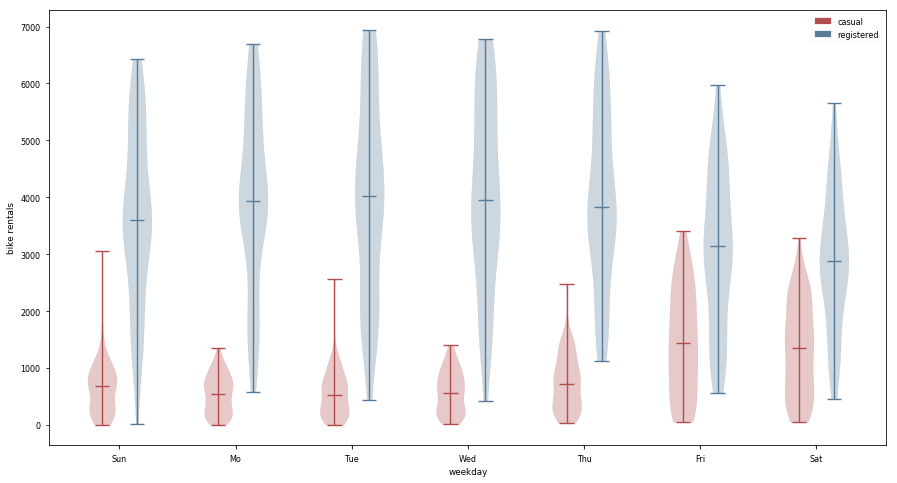

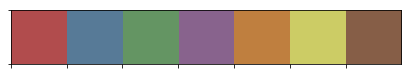

In [654]:
fig, ax = plt.subplots(1, 1, figsize=(15,8))
weekdays = [0, 1, 2, 3, 4, 5, 6]
rider_types = ['casual', 'registered']
positions_array = np.arange(len(weekdays))
colors = sns.color_palette("Set1", n_colors=len(weekdays), desat=.5)
sns.palplot(colors)
fake_handles = []

for i, rider_type in enumerate(rider_types):
    offset = .15 * (-1 if i == 0 else 1)
    violin = ax.violinplot([
        bikes_by_day[bikes_by_day['weekday'] == wd][rider_type].values
        for wd in weekdays
    ], positions=positions_array + offset, widths=.25, showmedians=True, showextrema=True)

    # Set the color
    color = colors[i]
    for part_name, part in violin.items():
        if part_name == 'bodies':
            for body in violin['bodies']:
                body.set_color(color)
        else:
            part.set_color(color)
    fake_handles.append(mpatches.Patch(color=color))

ax.legend(fake_handles, rider_types)
ax.set_xticks(positions_array, weekdays)
ax.set_xticklabels(['', 'Sun', 'Mo', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'])
ax.set_xlabel("weekday")
ax.set_ylabel("bike rentals");

In [649]:
ax.get_xticks().tolist()

[-1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]

*your answer here*
more casual bike rentals during the weekend

#### **2.5** Use `bikes_by_day` to visualize how the distribution of **total number of rides** per day (casual and registered riders combined) varies with the **season**. Do you see any **outliers**? Here we use the pyplot's boxplot function definition of an outlier as any value 1.5 times the IQR above the 75th percentile or 1.5 times the IQR below the 25th percentiles. If you see any outliers, identify those dates and investigate if they are a chance occurence, an error in the data collection, or a significant event (an online search of those date(s) might help). 

In [772]:
# your code here 
bikes_by_day.head()

,dteday,weekday,weather,season,temp,atemp,windspeed,hum,casual,registered,counts
0,2011-01-01 12:00:00,5,3,1,0.344167,0.363625,0.160446,0.805833,331,654,985
1,2011-01-02 12:00:00,6,3,1,0.363478,0.353739,0.248539,0.696087,131,670,801
2,2011-01-03 12:00:00,0,1,1,0.196364,0.189405,0.248309,0.437273,120,1229,1349
3,2011-01-04 12:00:00,1,2,1,0.200000,0.212122,0.160296,0.590435,108,1454,1562
4,2011-01-05 12:00:00,2,1,1,0.226957,0.229270,0.186900,0.436957,82,1518,1600


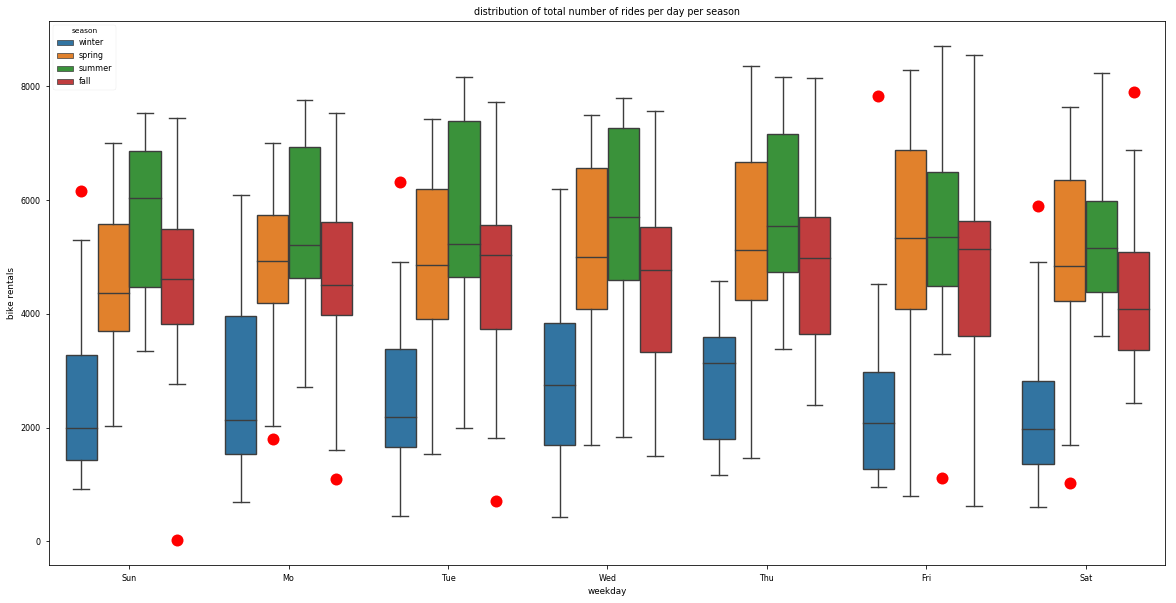

In [785]:
bikes_by_day.season = bikes_by_day.season.replace(1, 'winter').replace(2, 'spring').replace(3, 'summer').replace(4, 'fall')
fig, ax = plt.subplots(figsize=(20,10))
flierprops = dict(marker='o', markerfacecolor='r', markersize=12,
                  linestyle='none', markeredgecolor='g')
sns.boxplot(x="weekday", y="counts", hue="season", data=bikes_by_day, flierprops=flierprops, ax=ax)
ax.set_title('distribution of total number of rides per day per season')
ax.set_xticklabels(['Sun', 'Mo', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'])
ax.set_ylabel('bike rentals')
plt.show()

In [791]:
# your code here
outlier1 = bikes_by_day.loc[(bikes_by_day.weekday==0) & (bikes_by_day.season=='winter') & (bikes_by_day.counts>6000)]
outlier2 = bikes_by_day.loc[(bikes_by_day.weekday==0) & (bikes_by_day.season=='fall') & (bikes_by_day.counts<100)]
outlier3 = bikes_by_day.loc[(bikes_by_day.weekday==1) & (bikes_by_day.season=='spring') & (bikes_by_day.counts<2000)]
outlier4 = bikes_by_day.loc[(bikes_by_day.weekday==2) & (bikes_by_day.season=='winter') & (bikes_by_day.counts>6000)]
outlier5 = bikes_by_day.loc[(bikes_by_day.weekday==0) & (bikes_by_day.season=='winter') & (bikes_by_day.counts>6000)]
outlier4

,dteday,weekday,weather,season,temp,atemp,windspeed,hum,casual,registered,counts
438,2012-03-14 12:00:00,2,2,winter,0.5725,0.548617,0.115063,0.507083,997,5315,6312


In [19]:
# your code here
bikes_by_day.loc[(bikes_by_day.weekday==0) & (bikes_by_day.season==2) & (bikes_by_day.counts==1027)]

In [20]:
# your code here 


*your answer here* 


<div class='exercise'> <b> Question 3: Prepare the data for Regression </b> </div>

In order to build and evaluate our regression models, a little data cleaning is needed.  In this problem, we will explicitly create binary variables to represent the categorical predictors, set up the train-test split in a careful way, remove ancillary variables, and do a little data exploration that will be useful to consider in the regression models later.

**3.1** Using `bikes_df`, with hourly data about rentals, convert the categorical attributes ('season', 'month', 'weekday', 'weather') into multiple binary attributes using **one-hot encoding**.

**3.2** Split the updated `bikes_df` dataset in a train and test part. Do this in a 'stratified' fashion, ensuring that all months are equally represented in each set. Explain your choice for a splitting algorithm. 

**3.3** Although we asked you to create your train and test set, but for consistency and easy checking, we ask that for the rest of this problem set you use the train and test set provided in the he files `data/BSS_train.csv` and `data/BSS_test.csv`. Read these two files into dataframes `BSS_train` and `BSS_test`, respectively. Remove the `dteday` column from both the train and the test dataset (its format cannot be used for analysis). Also, remove any predictors that would make predicting the `count` trivial. Note we gave more meaningful names to the one-hot encoded variables.



#### Answers

#### **3.1** Using `bikes_df`, with hourly data about rentals, convert the categorical attributes ('season', 'month', 'weekday', 'weather') into multiple binary attributes using **one-hot encoding**.

In [423]:
# your code here
bikes_df_encoded = pd.get_dummies(bikes_df, columns=['season', 'month', 'weekday', 'weather'])

In [260]:
#your code here
bikes_df_encoded.head()

,dteday,hour,holiday,workingday,temp,atemp,hum,windspeed,casual,registered,...,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weather_1,weather_2,weather_3,weather_4
0,2011-01-01,0,0,0,0.24,0.2879,0.81,0.0,3,13,...,0,0,0,0,0,1,1,0,0,0
1,2011-01-01,1,0,0,0.22,0.2727,0.80,0.0,8,32,...,0,0,0,0,0,1,1,0,0,0
2,2011-01-01,2,0,0,0.22,0.2727,0.80,0.0,5,27,...,0,0,0,0,0,1,1,0,0,0
3,2011-01-01,3,0,0,0.24,0.2879,0.75,0.0,3,10,...,0,0,0,0,0,1,1,0,0,0
4,2011-01-01,4,0,0,0.24,0.2879,0.75,0.0,0,1,...,0,0,0,0,0,1,1,0,0,0


In [297]:
#your code here


In [298]:
# your code here


((13898, 39), (3481, 39), (17379, 39))

In [299]:
#your code here


####  **3.2** Split the updated `bikes_df` dataset in a train and test part. Do this in a 'stratified' fashion, ensuring that all months are equally represented in each set. Explain your choice for a splitting algorithm.

** Explanation **
We use sklearn train_test_split function with the parameter stratify.
In order to have an equal representation of each of the 24 months, we select the year and the binary attributes representing the months
We catch exceptions in case of missing data.

In [760]:
# your code here
months_list = ['year', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12']
try:
    # Stratify doesn't work if a value is missing
    train_data, test_data = train_test_split(bikes_df_encoded, test_size = 0.2, stratify=bikes_df_encoded[months_list])
except:
    # Drop missing lines
    print("Lines with missing values dropped")
    bikes_df_encoded = bikes_df_encoded.dropna(subset=months_list)
    train_data, test_data = train_test_split(bikes_df_encoded, test_size = 0.2, stratify=bikes_df_encoded[months_list])

** Explanation **

The stratification produces a test set where all 24 months are represented equally, with $144\pm4$ data points. Similarly we have $579\pm17$ data points per month in the training set.

In [768]:
test_data_monthly_count = test_data.groupby(months_list).aggregate(['count'])['hour']
np.mean(test_data_monthly_count), np.std(test_data_monthly_count)

(count    144.833333
 dtype: float64, count    4.588633
 dtype: float64)

In [769]:
train_data_monthly_count = train_data.groupby(months_list).aggregate(['count'])['hour']
np.mean(train_data_monthly_count), np.std(train_data_monthly_count)

(count    579.291667
 dtype: float64, count    17.903629
 dtype: float64)

*your answer here*



#### **3.3** Although we asked you to create your train and test set, but for consistency and easy checking, we ask that for the rest of this problem set you use the train and test set provided in the he files `data/BSS_train.csv` and `data/BSS_test.csv`. Read these two files into dataframes `BSS_train` and `BSS_test`, respectively. Remove the `dteday` column from both the train and the test dataset (its format cannot be used for analysis). Also, remove any predictors that would make predicting the `count` trivial. Note we gave more meaningful names to the one-hot encoded variables.

In [732]:
# your code here
BSS_train = pd.read_csv('data/BSS_train.csv')
BSS_test = pd.read_csv('data/BSS_test.csv')
BSS_train.shape
BSS_train.describe()

,Unnamed: 0,hour,holiday,year,workingday,temp,atemp,hum,windspeed,casual,...,Dec,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm
count,13903.000000,13903.000000,13903.000000,13903.000000,13903.000000,13903.000000,13903.000000,13903.000000,13903.000000,13903.000000,...,13903.000000,13903.000000,13903.000000,13903.000000,13903.000000,13903.000000,13903.000000,13903.000000,13903.00000,13903.000000
mean,8707.333166,11.529454,0.029274,0.504567,0.680644,0.496732,0.475426,0.629051,0.190025,35.414515,...,0.085305,0.140977,0.141121,0.144861,0.140833,0.142128,0.145508,0.260375,0.08286,0.000144
std,5012.167209,6.917884,0.168580,0.499997,0.466244,0.192699,0.171951,0.193100,0.122009,48.838431,...,0.279346,0.348010,0.348158,0.351973,0.347862,0.349194,0.352625,0.438855,0.27568,0.011993
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.020000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,4360.500000,6.000000,0.000000,0.000000,0.000000,0.340000,0.333300,0.480000,0.104500,4.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
50%,8721.000000,11.000000,0.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,16.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
75%,13051.500000,18.000000,0.000000,1.000000,1.000000,0.660000,0.621200,0.780000,0.253700,48.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000
max,17378.000000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.850700,367.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000


In [733]:
# casual and registered removed as they make predicting count trivial
select_columns = ['dteday', 'casual', 'registered', 'Unnamed: 0']
BSS_train = BSS_train.drop(columns = select_columns)
BSS_test = BSS_test.drop(columns = select_columns)

In [427]:
# your code here
BSS_test.groupby(['hour'])

<div class='exercise'> <b> Question 4: Multiple Linear Regression </b> </div>

**4.1** Use statsmodels to fit a multiple linear regression model to the training set using all the predictors (no interactions or polynomial terms) to predict `counts`, and report its $R^2$ score on the train and test sets.

**4.2** Examine the estimated coefficients and report which ones are statistically significant at a significance level of 5% (p-value < 0.05). You should see some strange values, such as `July` producing 93 fewer rentals, all else equal, than January.

**4.3** To diagnose the model, make two plots: first a histogram of the residuals, and second a plot of the residuals of the fitted model ${e} = y - \hat{y}$ as a function of the predicted value $\hat{y}$. Draw a horizontal line denoting the zero residual value on the Y-axis. What do the plots reveal about the OLS assumptions (linearity, constant variance, and normality)?

**4.4** Perhaps we can do better via a model with polynomial terms. Build a dataset `X_train_poly` from `X_train` with added $x^2$ terms for `temp`, `hour`, and `humidity`. Are these polynomial terms important? How does predicted ridership change as each of `temp`, `hour`, and `humidity` increase?

**4.5** The strange coefficients from 4.2 could also come from _multicolinearity_, where one or more predictors capture the same information as existing predictors. Why can multicolinearity lead to erroneous coefficient values? Create a temporary dataset `X_train_drop` that drops the following 'redundant' predictors from `X_train`:  `workingday` `atemp` `spring` `summer` and `fall`. Fit a multiple linear regression model to `X_train_drop`. Are the estimates more sensible in this model?


### Answers
#### **4.1** Use statsmodels to fit a multiple linear regression model to the training set using all the predictors (no interactions or polynomial terms) to predict `counts`, and report its $R^2$ score on the train and test sets.

In [444]:
# your code here
predictors = ['hour', 'holiday', 'workingday', 'temp', 'atemp', 'hum',
       'windspeed', 'spring', 'summer', 'fall', 'Feb', 'Mar', 'Apr',
       'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'Mon', 'Tue',
       'Wed', 'Thu', 'Fri', 'Sat', 'Cloudy', 'Snow', 'Storm']
design_mat_train = BSS_train[predictors]
design_mat_train = sm.add_constant(design_mat_train)


In [431]:
BSS_train[(BSS_train.holiday == 1) & (BSS_train.workingday == 1)]

,hour,holiday,workingday,temp,atemp,hum,windspeed,counts,spring,summer,...,Dec,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm


In [448]:
fitted_model_train = OLS(BSS_train.counts, design_mat_train).fit()
fitted_model_train.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 counts   R-squared:                       0.363
Model:                            OLS   Adj. R-squared:                  0.361
Method:                 Least Squares   F-statistic:                     272.0
Date:                Mon, 01 Oct 2018   Prob (F-statistic):               0.00
Time:                        15:13:42   Log-Likelihood:                -88804.
No. Observations:               13903   AIC:                         1.777e+05
Df Residuals:                   13873   BIC:                         1.779e+05
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         29.7713      8.803      3.382      0.001      12.515      47.027
hour           6.8941      0.191     36.113      0.000       6.520       7.268
holiday      -18.0549      6.837     -2.641      0.008     -31.457      -4.653
workingday    10.3639      2.851      3.635      0.000       4.776      15.952
temp         382.9725     45.742      8.373      0.000     293.313     472.632
atemp         60.9596     47.886      1.273      0.203     -32.904     154.824
hum         -226.1822      8.057    -28.073      0.000    -241.975    -210.389
windspeed      8.7508     11.136      0.786      0.432     -13.077      30.578
spring        46.0540      7.687      5.991      0.000      30.987      61.121
summer        28.6217      9.093      3.148      0.002      10.799      46.444
fall          66.4476      7.764      8.559      0.000      51.229      81.666
Feb          -11.0572      6.182     -1.789      0.074     -23.174       1.060
Mar          -20.1046      6.902     -2.913      0.004     -33.633      -6.576
Apr          -54.8396     10.228     -5.362      0.000     -74.888     -34.791
May          -50.3313     10.913     -4.612      0.000     -71.721     -28.941
Jun          -86.5310     11.086     -7.805      0.000    -108.261     -64.801
Jul         -113.1817     12.510     -9.047      0.000    -137.703     -88.660
Aug          -77.5771     12.249     -6.334      0.000    -101.586     -53.568
Sept         -28.9347     10.952     -2.642      0.008     -50.402      -7.468
Oct          -25.6482     10.220     -2.510      0.012     -45.680      -5.616
Nov          -29.8654      9.873     -3.025      0.002     -49.218     -10.513
Dec          -12.7773      7.890     -1.619      0.105     -28.243       2.689
Mon           -2.5827      3.087     -0.837      0.403      -8.633       3.467
Tue           -6.5175      3.324     -1.961      0.050     -13.033      -0.001
Wed            2.4441      3.299      0.741      0.459      -4.022       8.910
Thu           -3.5289      3.301     -1.069      0.285      -9.999       2.941
Fri            2.4939      3.302      0.755      0.450      -3.978       8.965
Sat           13.2741      4.541      2.923      0.003       4.373      22.175
Cloudy         9.5809      3.004      3.190      0.001       3.693      15.469
Snow         -27.0621      4.994     -5.419      0.000     -36.851     -17.273
Storm         49.1380    101.958      0.482      0.630    -150.713     248.989
==============================================================================
Omnibus:                     3457.396   Durbin-Watson:                   0.702
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8105.093
Skew:                           1.397   Prob(JB):                         0.00
Kurtosis:                       5.486   Cond. No.                     1.17e+16
==

In [ ]:
fitted_model_test.predict()

In [432]:
# your code here
design_mat_test = BSS_test[predictors]
design_mat_test = sm.add_constant(design_mat_test)
fitted_model_test = OLS(BSS_test.counts, design_mat_test).fit()
fitted_model_test.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 counts   R-squared:                       0.362
Model:                            OLS   Adj. R-squared:                  0.356
Method:                 Least Squares   F-statistic:                     67.31
Date:                Mon, 01 Oct 2018   Prob (F-statistic):          3.43e-309
Time:                        15:02:15   Log-Likelihood:                -22322.
No. Observations:                3476   AIC:                         4.470e+04
Df Residuals:                    3446   BIC:                         4.489e+04
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.6584     18.233      0.475      0.635     -27.091      44.407
hour           7.1120      0.400     17.797      0.000       6.328       7.895
holiday      -33.9508     14.706     -2.309      0.021     -62.783      -5.118
workingday     7.6717      5.999      1.279      0.201      -4.091      19.434
temp         237.8634    100.891      2.358      0.018      40.052     435.675
atemp        256.2959    105.782      2.423      0.015      48.894     463.698
hum         -209.8955     16.801    -12.493      0.000    -242.836    -176.955
windspeed     20.2750     23.020      0.881      0.379     -24.859      65.409
spring        39.6395     15.971      2.482      0.013       8.326      70.953
summer        -4.1807     18.953     -0.221      0.825     -41.340      32.979
fall          59.0549     15.802      3.737      0.000      28.072      90.038
Feb          -15.8978     12.931     -1.229      0.219     -41.252       9.456
Mar          -30.0397     14.440     -2.080      0.038     -58.352      -1.727
Apr          -44.4763     21.531     -2.066      0.039     -86.690      -2.262
May          -42.9722     22.900     -1.876      0.061     -87.872       1.928
Jun         -102.1927     23.334     -4.379      0.000    -147.944     -56.442
Jul          -90.4117     26.205     -3.450      0.001    -141.791     -39.032
Aug          -54.5326     25.725     -2.120      0.034    -104.970      -4.095
Sept          -0.0032     23.030     -0.000      1.000     -45.157      45.151
Oct           -9.6370     21.183     -0.455      0.649     -51.170      31.896
Nov          -25.8952     20.451     -1.266      0.206     -65.992      14.201
Dec          -17.5375     15.912     -1.102      0.270     -48.734      13.659
Mon           -5.9202      6.314     -0.938      0.348     -18.300       6.459
Tue            3.8834      6.949      0.559      0.576      -9.742      17.509
Wed          -13.4211      7.112     -1.887      0.059     -27.365       0.523
Thu          -10.7724      6.785     -1.588      0.112     -24.075       2.530
Fri           -0.0489      6.748     -0.007      0.994     -13.278      13.181
Sat            7.7478      9.577      0.809      0.419     -11.030      26.526
Cloudy        11.1575      6.220      1.794      0.073      -1.039      23.354
Snow         -19.7212     10.734     -1.837      0.066     -40.767       1.325
Storm         98.4388    150.010      0.656      0.512    -195.678     392.556
==============================================================================
Omnibus:                      855.005   Durbin-Watson:                   1.578
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1945.210
Skew:                           1.383   Prob(JB):                         0.00
Kurtosis:                       5.403   Cond. No.                     1.16e+16
==

In [433]:
print("The r2 score for train set is {0:8.6f} while the r2 score for test score is {0:8.6f} and {0:8.6f} ".format(fitted_model_test.rsquared, fitted_model_test.rsquared))

The r2 score for train set is 0.361629 while the r2 score for test score is 0.361629 and 0.361629 


In [434]:
fitted_model_test.rsquared

0.36162894734057804

#### **4.2** Examine the estimated coefficients and report which ones are statistically significant at a significance level of 5% (p-value < 0.05). You should see some strange values, such as `July` producing 93 fewer rentals, all else equal, than January.

In [468]:
# your code here
# significant predictors
fitted_model_train.pvalues[fitted_model_train.pvalues<0.05].sort_values()

hour          5.035630e-273
hum           1.046913e-168
Jul            1.659676e-19
fall           1.262206e-17
temp           6.175793e-17
Jun            6.357603e-15
Aug            2.469807e-10
spring         2.130833e-09
Snow           6.091624e-08
Apr            8.383003e-08
May            4.019757e-06
workingday     2.785044e-04
const          7.221248e-04
Cloudy         1.428010e-03
summer         1.648350e-03
Nov            2.490934e-03
Sat            3.469374e-03
Mar            3.586847e-03
Sept           8.250241e-03
holiday        8.282163e-03
Oct            1.209469e-02
Tue            4.994960e-02
dtype: float64

In [436]:
# your code here
# not significant predictors
fitted_model_train.pvalues[fitted_model_train.pvalues>=0.05]

atemp           0.786484
Feb             0.411316
Mar             0.521325
Sept            0.296307
Oct             0.110418
Dec             0.054051
Mon             0.414128
Tue             0.180925
Wed             0.422420
Thu             0.844856
Fri             0.183727
Cloudy          0.073626
Storm           0.592983
temp_squared    0.709715
dtype: float64

*your answer here*
are statistically significant at a significance level of 5% (p-value < 0.05)

#### **4.3** To diagnose the model, make two plots: first a histogram of the residuals, and second a plot of the residuals of the fitted model ${e} = y - \hat{y}$ as a function of the predicted value $\hat{y}$. Draw a horizontal line denoting the zero residual value on the Y-axis. What do the plots reveal about the OLS assumptions (linearity, constant variance, and normality)?

In [442]:
design_mat_train.head()

,const,hour,holiday,workingday,temp,atemp,hum,windspeed,spring,summer,...,Dec,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm
0,1.0,0,0,0,0.24,0.2879,0.81,0.0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,1.0,1,0,0,0.22,0.2727,0.80,0.0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,1.0,2,0,0,0.22,0.2727,0.80,0.0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,1.0,3,0,0,0.24,0.2879,0.75,0.0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,1.0,4,0,0,0.24,0.2879,0.75,0.0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [450]:

predicted_counts = fitted_model_train.predict(design_mat_test)
predicted_counts[predicted_counts<0]
predicted_score = r2_score(BSS_test.counts, predicted_counts)
predicted_score

0.3540158642944239

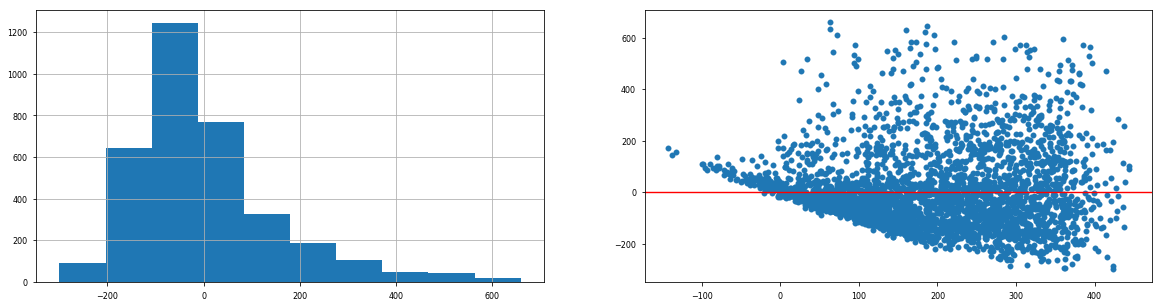

In [451]:
# your code here
fig, ax = plt.subplots(1,2,figsize=(20,5))
fitted_model_test.resid.hist(ax=ax[0])
ax[1].scatter(predicted_counts, fitted_model_test.resid)
ax[1].axhline(0, 0, 1, color='r')

*your answer here* 

The residuals are not centered at zero.

#### **4.4** Perhaps we can do better via a model with polynomial terms. Build a dataset `X_train_poly` from `X_train` with added $x^2$ terms for `temp`, `hour`, and `humidity`. Are these polynomial terms important? How does predicted ridership change as each of `temp`, `hour`, and `humidity` increase?

In [520]:
# your code here
X_train_poly = BSS_train.copy()
X_train_poly["temp_squared"] = X_train_poly.temp ** 2
X_train_poly["hour_squared"] = X_train_poly.hour ** 2
X_train_poly["hum_squared"] = X_train_poly.hum ** 2
X_test_poly = BSS_train.copy()
X_test_poly["temp_squared"] = X_test_poly.temp ** 2
X_test_poly["hour_squared"] = X_test_poly.hour ** 2
X_test_poly["hum_squared"] = X_test_poly.hum ** 2

In [452]:
predictors_poly = ['hour', 'holiday', 'workingday', 'temp', 'atemp', 'hum',
       'windspeed', 'spring', 'summer', 'fall', 'Feb', 'Mar', 'Apr',
       'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'Mon', 'Tue',
       'Wed', 'Thu', 'Fri', 'Sat', 'Cloudy', 'Snow', 'Storm', 'temp_squared', 'hour_squared', 'hum_squared']
design_mat_train_poly = X_train_poly[predictors_poly]
design_mat_train_poly = sm.add_constant(design_mat_train_poly)
fitted_model_train_poly = OLS(X_train_poly.counts, design_mat_train_poly).fit()

In [526]:
design_mat_test_poly = X_test_poly[predictors_poly]
design_mat_test_poly = sm.add_constant(design_mat_test_poly)
predicted_counts = fitted_model_train_poly.predict(design_mat_test_poly)
predicted_counts.shape, BSS_test.temp.shape, design_mat_test_poly.shape

((13903,), (3476,), (13903, 34))

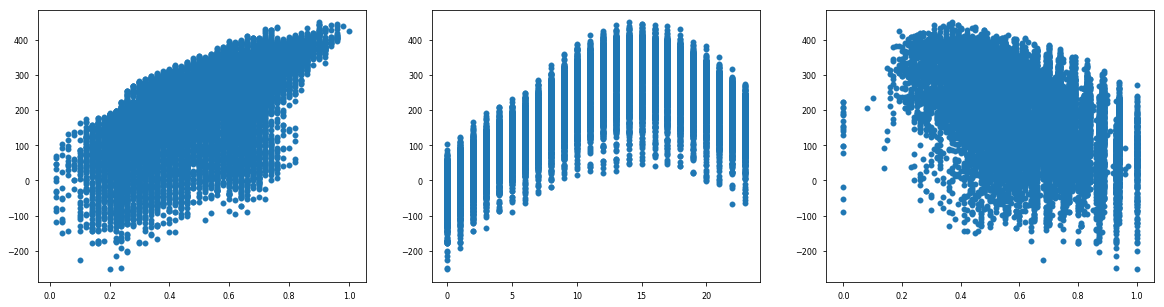

In [527]:
fig, ax = plt.subplots(1,3,figsize=(20,5))
ax[0].scatter(X_test_poly.temp, predicted_counts)
ax[1].scatter(X_test_poly.hour, predicted_counts)
ax[2].scatter(X_test_poly.hum, predicted_counts)

*your answer here*
The ridership increases as temperature increases up to 0.9, then it starts decreasing.
The ridership increases during the day till 6 PM, with peaks around 8 AM and 5 PM, then it starts decreasing.
The ridership is high with humidity between 0.2 and 0.9.

#### **4.5** The strange coefficients from 4.2 could also come from _multicolinearity_, where one or more predictors capture the same information as existing predictors. Why can multicolinearity lead to erroneous coefficient values? Create a temporary dataset `X_train_drop` that drops the following 'redundant' predictors from `X_train`:  `workingday` `atemp` `spring` `summer` and `fall`. Fit a multiple linear regression model to `X_train_drop`. Are the estimates more sensible in this model?

In [466]:
# your code here
X_train_drop = design_mat_train_poly.copy()
X_train_drop = design_mat_train_poly.drop(columns = ['workingday', 'atemp', 'spring', 'summer', 'fall'])
fitted_model_train_poly_clean = OLS(X_train_poly.counts, design_mat_train_poly).fit()
fitted_model_train_poly_clean.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 counts   R-squared:                       0.452
Model:                            OLS   Adj. R-squared:                  0.451
Method:                 Least Squares   F-statistic:                     357.5
Date:                Mon, 01 Oct 2018   Prob (F-statistic):               0.00
Time:                        15:33:25   Log-Likelihood:                -87752.
No. Observations:               13903   AIC:                         1.756e+05
Df Residuals:                   13870   BIC:                         1.758e+05
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         -170.0037     14.680    -11.581      0.000    -198.778    -141.229
hour            38.4605      0.693     55.497      0.000      37.102      39.819
holiday        -12.6657      6.346     -1.996      0.046     -25.104      -0.227
workingday      12.1305      2.645      4.587      0.000       6.947      17.314
temp           346.6924     60.780      5.704      0.000     227.554     465.830
atemp           12.3483     45.585      0.271      0.786     -77.005     101.702
hum             76.0973     37.796      2.013      0.044       2.013     150.182
windspeed      -24.1249     10.382     -2.324      0.020     -44.475      -3.775
spring          46.3718      7.129      6.504      0.000      32.397      60.346
summer          34.7578      8.452      4.113      0.000      18.191      51.324
fall            70.3279      7.206      9.759      0.000      56.203      84.453
Feb             -4.7651      5.800     -0.822      0.411     -16.134       6.603
Mar             -4.2284      6.593     -0.641      0.521     -17.152       8.695
Apr            -31.2172      9.662     -3.231      0.001     -50.157     -12.278
May            -27.2006     10.233     -2.658      0.008     -47.259      -7.142
Jun            -50.3522     10.367     -4.857      0.000     -70.673     -30.031
Jul            -77.8098     11.676     -6.664      0.000    -100.697     -54.923
Aug            -49.7040     11.466     -4.335      0.000     -72.178     -27.230
Sept           -10.8007     10.341     -1.044      0.296     -31.071       9.470
Oct            -15.4695      9.690     -1.596      0.110     -34.463       3.524
Nov            -27.7146      9.317     -2.975      0.003     -45.976      -9.453
Dec            -14.2818      7.413     -1.927      0.054     -28.812       0.249
Mon             -2.3373      2.862     -0.817      0.414      -7.947       3.273
Tue             -4.1252      3.083     -1.338      0.181     -10.169       1.918
Wed              2.4544      3.059      0.802      0.422      -3.542       8.451
Thu             -0.5991      3.062     -0.196      0.845      -6.600       5.402
Fri              4.0719      3.063      1.329      0.184      -1.932      10.076
Sat             15.3448      4.212      3.643      0.000       7.088      23.602
Cloudy          -5.0215      2.807     -1.789      0.074     -10.523       0.480
Snow           -42.3194      4.800     -8.817      0.000     -51.728     -32.911
Storm           50.5439     94.558      0.535      0.593    -134.802     235.890
temp_squared   -14.1642     38.051     -0.372      0.710     -88.749      60.420
hour_squared    -1.3254      0.028    -47.160      0.000      -1.380      -1.270
hum_squared   -184.9746     30.250     -6.115      0.000    -244.268    -125.681
==============================================================================
Omnibus

In [467]:
fitted_model_train_poly_clean.bic

175818.6685174439

*your answer here*


<div class='exercise'><b> Question 5: Subset Selection </b> </div>
Perhaps we can automate finding a good set of predictors. This question focuses on forward stepwise selection, where predictors are added to the model one by one.

**5.1** Implement forward step-wise selection to select a minimal subset of predictors that are related to the response variable. Run your code on the richest dataset, `X_train_poly`, and determine which predictors are selected.

We require that you implement the method **from scratch**. You may use the Bayesian Information Criterion (BIC) to choose the best subset size. 

<i>Note: Implementing from scratch means you are not allowed to use a solution provided by a Python library, such as sklearn or use a solution you found on the internet. You have to write all of the code on your own. However you MAY use the `model.bic` attribute implemented in statsmodels.</i>

**5.2** Does forward selection eliminate one or more of the colinear predictors we dropped in Question  4.5 (`workingday` `atemp` `spring` `summer` and `fall`)? If any of the five predictors are not dropped, explain why.

**5.3** Fit the linear regression model using the identified subset of predictors to the training set. How do the train and test $R^2$ scores for this fitted step-wise model compare with the train and test $R^2$ scores from the polynomial model fitted in Question 4.4?

### Answers

#### **5.1** Implement forward step-wise selection to select a minimal subset of predictors that are related to the response variable. Run your code on the richest dataset, `X_train_poly`, and determine which predictors are selected.

#### We require that you implement the method **from scratch**. You may use the Bayesian Information Criterion (BIC) to choose the best subset size. 

#### <i>Note: Implementing from scratch means you are not allowed to use a solution provided by a Python library, such as sklearn or use a solution you found on the internet. You have to write all of the code on your own. However you MAY use the `model.bic` attribute implemented in statsmodels.</i>

In [585]:
# your code here
def linear_regression(s):
    design_mat_train_poly_subset = X_train_poly[s]
    design_mat_train_poly_subset = sm.add_constant(design_mat_train_poly_subset)
    fitted_model_train_poly_subset = OLS(X_train_poly.counts, design_mat_train_poly_subset).fit()
    return fitted_model_train_poly_subset

predictors_all = ['hour', 'holiday', 'workingday', 'temp', 'atemp', 'hum',
       'windspeed', 'spring', 'summer', 'fall', 'Feb', 'Mar', 'Apr',
       'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'Mon', 'Tue',
       'Wed', 'Thu', 'Fri', 'Sat', 'Cloudy', 'Snow', 'Storm', 'temp_squared', 'hour_squared', 'hum_squared']



In [586]:
# your code here
def linear_regression(s):
    design_mat_train_poly_subset = X_train_poly[s]
    design_mat_train_poly_subset = sm.add_constant(design_mat_train_poly_subset)
    fitted_model_train_poly_subset = OLS(X_train_poly.counts, design_mat_train_poly_subset).fit()
    return fitted_model_train_poly_subset

def select_next_predictor(current_predictors, candidate_predictors):
    model = linear_regression(current_predictors)
    min_bic = model.bic
    best_predictor = None
    for predictor in candidate_predictors:
        current_predictors_copy = current_predictors.copy()
        current_predictors_copy.append(predictor)
        model = linear_regression(current_predictors_copy)
        if model.bic < min_bic:
            best_predictor = predictor
            best_model = model
            min_bic = model.bic
    if best_predictor != None:
        current_predictors.append(best_predictor)
        return True
    else:
        return False
    
candidates_predictors = ['holiday', 'workingday', 'temp', 'atemp', 'hum',
       'windspeed', 'spring', 'summer', 'fall', 'Feb', 'Mar', 'Apr',
       'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'Mon', 'Tue',
       'Wed', 'Thu', 'Fri', 'Sat', 'Cloudy', 'Snow', 'Storm', 'temp_squared', 'hour_squared', 'hum_squared']

# forward predictors selection using BIC

selected_predictors = ['hour']
while len(candidates)>0:
    if select_next_predictor(selected_predictors, candidates_predictors):
        candidates_predictors.remove(selected_predictors[-1])
    else:
        break
          

In [587]:
# your code here
print("selected predictors: ", selected_predictors)
print("eliminated predictors: ", set(predictors_all)- set(selected_predictors))
best_model = linear_regression(selected_predictors)
print("R2: ", best_model.rsquared)
print("BIC: ", best_model.bic) 

selected predictors:  ['hour', 'hour_squared', 'temp', 'hum_squared', 'fall', 'Jul', 'Snow', 'spring', 'Sept', 'holiday', 'Jun']
eliminated predictors:  {'Sat', 'atemp', 'Wed', 'windspeed', 'hum', 'Tue', 'Apr', 'Mar', 'summer', 'Oct', 'Dec', 'Aug', 'workingday', 'May', 'Cloudy', 'Feb', 'Nov', 'Mon', 'Storm', 'temp_squared', 'Fri', 'Thu'}
R2:  0.44932698124455916
BIC:  175686.6398322799


#### **5.2** Does forward selection eliminate one or more of the colinear predictors we dropped in Question  4.5 (`workingday` `atemp` `spring` `summer` and `fall`)? If any of the five predictors are not dropped, explain why.

*your answer here*


#### **5.3** Fit the linear regression model using the identified subset of predictors to the training set. How do the train and test $R^2$ scores for this fitted step-wise model compare with the train and test $R^2$ scores from the polynomial model fitted in Question 4.4?

In [588]:
# your code here
design_mat_test_poly = X_test_poly[selected_predictors]
design_mat_test_poly = sm.add_constant(design_mat_test_poly)
predicted_counts_test = best_model.predict(design_mat_test_poly)

design_mat_train_poly = X_train_poly[selected_predictors]
design_mat_train_poly = sm.add_constant(design_mat_train_poly)
predicted_counts_train = best_model.predict(design_mat_train_poly)

*your answer here*


#  Written Report to the Administrators [20 pts]
<br>

<div class='exercise'> <b> Question 6 </b> </div>

Write a short repost stating some of your findings on how the administrators can increase the bike share system's revenue. You might want to include suggestions such as what model to use to predict ridership, what additional services to provide, or when to give discounts, etc. 
Include your report as a pdf file in canvas. The report should not be longer than one page (300 words) and should include a maximum of 5 figures. 

#### Answers 6




*your answer here*


In [43]:
# your code here


*your answer here* 


In [44]:
#your code here


*your answer here* 
